In [ ]:
BATCH_SIZE = 64 # @param [32, 64, 128]
HIDDEN_UNITS = 12 # @param [8, 10, 12, 16]
EPOCHS = 3 # @param [3, 4, 5, 7]

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [ ]:
!pip install torchmetrics

In [ ]:
# Based agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, RandomRotation, RandomAffine

# This is using the unbalanced dataset described here:
# https://arxiv.org/pdf/1702.05373v1.pdf

orient_direction = transforms.Compose([
    ToTensor(),
    RandomRotation((90, 90)),  # Rotate 90 degrees
    Lambda(lambda x: torch.flip(x, (0, 1))),  # Flip horizontally
    RandomAffine(  # Apply random transformations to make the dataset more robust
        degrees=25,
        translate=(0.45, 0.45),
        scale=(0.6, 1),
        shear=(-30, 30, -30, 30)
    )
])

train_data = datasets.EMNIST(
    root='data',
    split='byclass',
    train=True,
    download=True,
    transform=orient_direction  # Ensure we receive a tensor
)

test_data = datasets.EMNIST(
    root='data',
    split='byclass',
    train=False,
    download=True,
    transform=orient_direction
)

100%|██████████| 561753746/561753746 [00:05<00:00, 93723128.20it/s]


Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw


In [ ]:
class_names = train_data.classes
print(f'{class_names=}')

class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


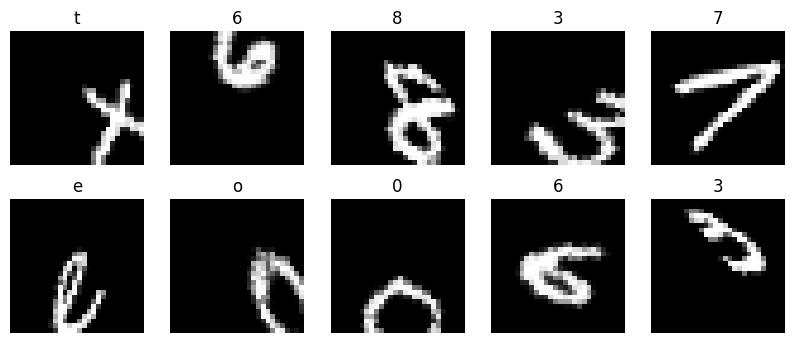

In [ ]:
### Plot 10 images
fig = plt.figure(figsize=(10, 4))
rows, cols = 2, 5
for i in range(1, rows * cols + 1):

    random_idx = torch.randint(0, len(train_data), size=[1]).item()  # Use item() to get the scalar
    img, label = train_data[random_idx]

    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

In [ ]:
### Define dataloaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

print(f'Train DataLoader: {train_dataloader}\nTest DataLoader: {test_dataloader}\n')
print(f'Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}')
print(f'Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}')

Train DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7b2a83526dd0>
Test DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7b2a83526f20>

Length of train dataloader: 10906 batches of 64
Length of test dataloader: 1818 batches of 64


In [ ]:
# A look inside the DataLoader-- (features format should be NCHW)
example_batch_features, example_batch_labels = next(iter(train_dataloader))
print(f'Features shape: {example_batch_features.shape}\nLabels shape: {example_batch_labels.shape}')

Features shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])


In [ ]:
### Define our model
# Using the TinyVGG CNN architecture from https://poloclub.github.io/cnn-explainer/
from torch import nn

class CharacterClassifer(nn.Module):
    def __init__(self, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1,  # 1 channel--black and white
                      out_channels=HIDDEN_UNITS,
                      kernel_size=3,  # Dimensions of inspecting square
                      stride=1,  # Default
                      padding=1),
            nn.ReLU(),  # Nonlinearity baby 😋
            nn.Conv2d(HIDDEN_UNITS, HIDDEN_UNITS, 3, padding=1),  # There're many channels of hidden units now
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)  # Default stride is the same as kernel
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(HIDDEN_UNITS, HIDDEN_UNITS, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(HIDDEN_UNITS, HIDDEN_UNITS, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(HIDDEN_UNITS * 7 * 7, output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

In [ ]:
### Make our model
model_0 = CharacterClassifer(output_shape=len(class_names)).to(device)
model_0

CharacterClassifer(
  (block_1): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=588, out_features=62, bias=True)
  )
)

In [ ]:
### Define optimizer, loss function, and accuracy function
import torchmetrics

accuracy_fn = torchmetrics.Accuracy(task='multiclass', num_classes=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
### Evaluation function

def evaluate_model(model: torch.nn.Module,
                   data_loader: torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module,
                   accuracy_fn: torchmetrics.metric.Metric,
                   device: torch.device):

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_pred.argmax(dim=1), y)

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {'model_name': model.__class__.__name__,
            'model_loss': loss.item(),
            'model_acc': acc}

In [ ]:
### Training and Testing Steps

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn: torchmetrics.metric.Metric,
               device: torch.device):
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()

    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_preds = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_preds, y)
        train_loss += loss

        batch_acc = accuracy_fn(y_preds.argmax(dim=1), y)
        train_acc += batch_acc

        # 3. Zero the optimizer gradients
        optimizer.zero_grad()

        # 4. Backpropagate
        loss.backward()

        # 5. SGD step
        optimizer.step()

    # Calculate loss and accuracy per epoch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f'Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%')


def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn: torchmetrics.metric.Metric,
              device: torch.device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:

            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(torch.argmax(test_pred, dim=1), y)

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f'Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n')

In [ ]:
### Training time function
import math

def print_train_time(start: float, end: float, device: torch.device):
    total_time = end - start
    minutes = math.floor(total_time / 60)
    seconds = total_time % 60
    print(f'Train time on {device}: {minutes} minutes and {seconds:.2f} seconds')

In [ ]:
### Train the model
from tqdm.auto import tqdm
from timeit import default_timer

begin_time = default_timer()

for epoch in tqdm(range(EPOCHS)):
    print(f'Epoch: {epoch}\n---------------------------------')

    # Train step
    train_step(model=model_0,
              data_loader=train_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              accuracy_fn=accuracy_fn,
              device=device
    )

    # Test step
    if epoch % 2 == 0 or epoch == EPOCHS - 1:
        test_step(model=model_0,
                  data_loader=test_dataloader,
                  loss_fn=loss_fn,
                  accuracy_fn=accuracy_fn,
                  device=device
        )

    print('')  # Newline

end_time = default_timer()
print_train_time(begin_time, end_time, device)

In [ ]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

STATE_DICT_NAME = 'character_classifier_state_dict.pth'
STATE_DICT_SAVE_PATH = MODEL_PATH / STATE_DICT_NAME

print(f'Saving state dict to: {STATE_DICT_SAVE_PATH}')
torch.save(obj=model_0.state_dict(),
           f=STATE_DICT_SAVE_PATH)

In [ ]:
MODEL_NAME = 'character_classifier.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=model_0,
           f=MODEL_SAVE_PATH)

In [ ]:
### Test that the model works

random_idx = torch.randint(0, len(train_data), size=[1]).item()
test_img, test_label = train_data[random_idx]

plt.imshow(test_img.squeeze(), cmap='gray')
plt.title(class_names[test_label])
test_img.shape

In [ ]:
model_0.to(device)
test_img.to(device)

model_0.eval()
with torch.inference_mode():

    pred_logit = model_0(test_img.unsqueeze(dim=0))
    pred_probs = torch.softmax(pred_logit.squeeze(), dim=0) # .squeeze(), dim=0)
    pred_class = pred_probs.argmax(dim=0)

print(f'The model guesses that the input is a: {class_names[pred_class]}')

In [ ]:
### Now convert to onnx format for use in browsers
!pip install onnx

In [ ]:
# Export to onnx
model_0.to('cpu')
dummy_input = torch.zeros(1, 1, 28, 28).to('cpu')

model_0.eval()
torch.onnx.export(model_0,
                  dummy_input,
                  'torchmodel_EMINST.onnx',
                  verbose=True,
                  opset_version=9)  # VERY IMPORTANT -- only works in v7-9

In [ ]:
### Now, need to make a model that's set up to work in browser

class CharClassiferWeb(nn.Module):
    def __init__(self, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1,  # 1 channel--black and white
                      out_channels=HIDDEN_UNITS,
                      kernel_size=3,  # Dimensions of inspecting square
                      stride=1,  # Default
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(HIDDEN_UNITS, HIDDEN_UNITS, 3, padding=1),  # There're many channels of hidden units now
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)  # Default stride is the same as kernel
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(HIDDEN_UNITS, HIDDEN_UNITS, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(HIDDEN_UNITS, HIDDEN_UNITS, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(HIDDEN_UNITS * 7 * 7, output_shape)
        )

    def forward(self, x: torch.Tensor):

        # Pre-process inputs
        x = x.reshape(280, 280, 4)
        x = torch.narrow(x, dim=2, start=3, length=1)  # Get the alpha color value
        x = x.reshape(1, 1, 280, 280)  # Put into NCHW format
        x = nn.functional.avg_pool2d(x, 10, stride=10)  # Lower resolution from 280x280 to 28x28
        x = x / 255  # Alpha value is 0-255, accomdate for that

        # Inference
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)

        # Post-process logits -> probabilites
        x = torch.softmax(x, dim=1)
        return x

In [ ]:
model_web = CharClassiferWeb(output_shape=len(class_names)).to('cpu')

In [ ]:
model_web.load_state_dict(model_0.state_dict())

In [ ]:
# Now, output to ONNX
model_web.to('cpu')
dummy_input = torch.zeros(280 * 280 * 4).to('cpu')

model_web.eval()
torch.onnx.export(model_web,
                  dummy_input,
                  'torchmodel_Web.onnx',
                  verbose=True,
                  opset_version=9)   # VERY IMPORTANT -- only works in v7-9